# Alternating-direction implicit

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

Implementing this method is a bit tricky. The code ends up being very simple, but it takes a bit of thinking to figure out the various matrix multiplications. 

Let's look at the first step:

$$T^{n+1/2}_{i,j} =  T^n_{i,j} + {\alpha\over 2}\left(T^{n+1/2}_{i-1,j} -2T^{n+1/2}_{i,j} + T^{n+1/2}_{i+1,j} + T^n_{i,j-1} -2T^n_{i,j} + T^n_{i,j+1}\right)$$

$$\Rightarrow - {\alpha\over 2}T^{n+1/2}_{i-1,j} + T^{n+1/2}_{i,j}(1+\alpha) - {\alpha\over 2}T^{n+1/2}_{i+1,j} =  {\alpha\over 2} T^n_{i,j-1}  + (1-\alpha) T^n_{i,j} + {\alpha\over 2}T^n_{i,j+1}.$$

This describes implicit diffusion in the $x$-direction and explicit diffusion in the $y$-direction. If we focus on the left-hand side and write

$$- {\alpha\over 2}T^{n+1/2}_{i-1,j} + T^{n+1/2}_{i,j}(1+\alpha) - {\alpha\over 2}T^{n+1/2}_{i+1,j} =  B_{i,j}$$

then we see that this actually describes $N$ problems of the form $\mathbf{A}\mathbf{x}=\mathbf{b}$, where $\mathbf{A}$ is the usual 1D diffusion operator ($N\times N$ matrix), $\mathbf{x}$ is column $j$ of $\mathbf{T}^{n+1}$ and the right-hand side vector is column $j$ of the matrix $\mathbf{B}$. There are $N$ equations to solve here because we have an equation for each column $j$.

The right-hand side matrix is given by

$$B_{i,j} =  {\alpha\over 2} T^n_{i,j-1}  + (1-\alpha) T^n_{i,j} + {\alpha\over 2}T^n_{i,j+1},$$

again a set of $N$ equations, one for each row $i$. We can therefore calculate $\mathbf{B}$ row by row by operating the 1D diffusion matrix on each row.

So, we see that we need to do two sweeps of the matrix: first sweep over the rows to calculate $\mathbf{B}$, and then sweep over the columns, solving the implicit equation for each column.
The second step of the ADI method is the same as the first except operating on the transpose of the matrix, so if we can implement the first step we just need to carry it out again to complete the full timestep.

The exercise as written was to solve the heat equation with fixed temperature boundaries, but to make things simpler (and to lead into our next section on Fourier transforms) consider instead a problem with $T=0$ on all the boundaries, and instead we'll evolve a Gaussian temperature perturbation. You might recall that the Green's function for the diffusion equation is

$$T(x, y, t) = {1\over 4\pi t} \exp\left(-{x^2+y^2\over 4t}\right)$$  

in 2D (this goes to a delta function as $t\rightarrow 0$). So if we start with this profile at some time $t_0$ we can evolve it to future times and compare against the analytic evolution.

Here is the code:

In [2]:
def gaussian(x, y, x0, t):
    # Green's function for the diffusion equation
    dx = x-x0[0]
    dy = y-x0[1]
    return np.exp(-(dx**2 + dy**2)/(4*t)) / (4*np.pi*t)

In [3]:
def construct_matrices(n, alpha):
    # This is the matrix for the explicit update on the RHS
    AR = np.diag((1-alpha)*np.ones(n)) + np.diag(alpha/2*np.ones(n-1),k=1) + np.diag(alpha/2*np.ones(n-1),k=-1)

    # and for the implicit update on the LHS
    b = 1 + alpha*np.ones(n)
    a = -alpha/2*np.ones(n)
    a[0] = 0
    c = -alpha/2*np.ones(n)
    c[-1] = 0
    AL = np.row_stack((a,b,c))

    return AL, AR

Using matplotlib backend: MacOSX
T range =  2.775641929741181e-09 13.347482336770343
delta range =  -0.00026729235363271396 0.0009687580085419478


<Figure size 1280x960 with 0 Axes>

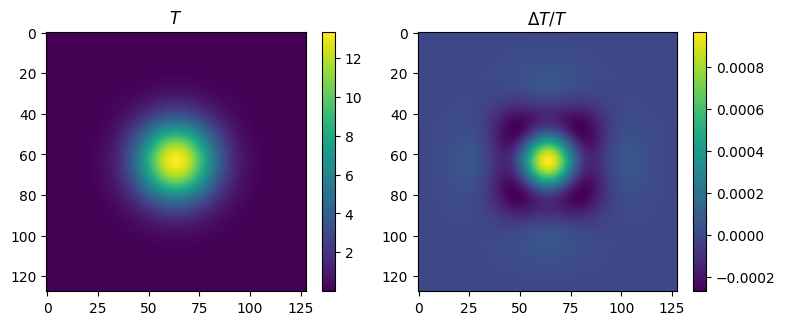

In [7]:
# set up the grid and initial condition
n = 128
T = np.zeros((n,n))
x = np.linspace(0,1,n)
dx = x[1]-x[0]
xx, yy = np.meshgrid(x, x)
x0 = (0.5, 0.5)   # location of the gaussian
t0 = 0.001   # initial time
T = gaussian(xx, yy, x0, t0)

# timesteps
alpha = 2
nsteps = 40
dt = alpha * dx**2
AL, AR = construct_matrices(n, alpha)

%matplotlib
plt.imshow(T)
plt.title("%d: t=%lg" % (0,t0))
plt.colorbar()
plt.show()

Tnew = np.zeros_like(T)
B = np.zeros_like(T)

# We take twice as many steps here because we are doing half-timesteps
for i in range(2*nsteps):

    # Compute the right-hand side matrix row by row
    for j in range(n):
        B[j,:] = AR @ T[j,:]

    # and now solve column by column for the new T
    for j in range(n):
        Tnew[:,j] = scipy.linalg.solve_banded((1,1), AL, B[:,j])

    # take the transpose to swap directions for the next half-step
    T = Tnew.T
    
    if i%2 == 1:
        ti = t0 + dt*(1 + i//2)
        plt.clf()
        plt.imshow(T)
        plt.title("%d: t=%lg" % (1 + i//2,ti))
        plt.colorbar()
        plt.show()
        plt.pause(1e-3)

# compare the result with the analytic one
ti = t0 + dt*(1 + i//2)
delta = (T - gaussian(xx, yy, x0, ti)) / np.max(T)
print("T range = ", np.min(T), np.max(T))
print("delta range = ", np.min(delta), np.max(delta))

%matplotlib inline
plt.clf()
fig = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(T)
plt.title(r'$T$')
plt.colorbar(shrink=0.7)
plt.subplot(122)
plt.imshow(delta)
plt.title(r'$\Delta T/T$')
plt.colorbar(shrink=0.7)
plt.tight_layout()
plt.show()